In [4]:
import importlib

import numpy as np
import random
import time
import pandas as pd
import os
import random
from tqdm import tqdm


# Signals
from scipy.stats import mannwhitneyu
from scipy import signal
from scipy.fft import fft, fftshift
from scipy.signal import welch
import scipy.signal

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)  


from matplotlib.colors import Normalize, LogNorm

import auxlib; importlib.reload(auxlib)

<module 'auxlib' from 'd:\\Facultad\\Doctorado\\Proyectos\\EEG\\auxlib.py'>

In [ ]:
saving_figs = os.path.join(os.getcwd(), 'figures/power_analisis_bandas')
if not os.path.exists(saving_figs):
	os.makedirs(saving_figs)

saving_files = os.path.join(os.getcwd(), 'media/power_analisis_bandas')
if not os.path.exists(saving_files):
	os.makedirs(saving_files)

<h2>Labeling</h2>

In [5]:
def task_labels(header):	
	t0_labels = []
	t1_labels = []
	t2_labels = []
	for task in range(len(header['annotations'])):
		if header['annotations'][task][2] == 'T1':
			t1_labels.append(header['annotations'][task][0])
		elif header['annotations'][task][2] == 'T2':
			t2_labels.append(header['annotations'][task][0])
		else:
			t0_labels.append(header['annotations'][task][0])
	return t0_labels, t1_labels, t2_labels

<h2>Power Density</h2>

In [6]:
# Power Density Spectrum Porcentual
# Parameters
# x: Signal to convert
# fs: sample frequency
# nfft: fft length, padded with 0
# Outputs
# Psd_per: Power Spectarl Density in %, the sum of all vector is 1 (is equal to integrate 0 - fs/2) 
# Pxx: Power Spectral Density
# X: FFT mod of x
# f: frequency scale.

def psd_percentage(x, fs, nfft):
	
	N = nfft
	X = abs(fft(x, n=nfft))/N
	Pxx = X**2
	X = X[0:int(N/2)+1]
	X[1:int(N/2)] = 2*X[1:int(N/2)] # duplicate except 0
	
	Pxx = Pxx[0:int(N/2)+1]
	
	Pxx[1:int(N/2)] = 2*Pxx[1:int(N/2)]

	#Psd = (1/fs*N)*abs(fft(x, n=nfft))**2
	#Psd = Psd[0:int(N/2)+1]
	#Psd[1:int(N/2)] = 2*Psd[1:int(N/2)] # duplicate except 0
	
	f, S = scipy.signal.periodogram(x, fs,  nfft=nfft, scaling='spectrum')

	#psd_sum = sum(Psd)
	
	#Psd_per= Psd/psd_sum
	
	#Psd_per= (nfft/fs)*(Psd/psd_sum)
	
	#f = (fs/N)*np.arange(0, int(N/2)+1, 1) = S
	
	Psd_per = S
	f_dif = f[1]-f[0]
	
	psd_sum = sum(Psd_per) * 2 * f_dif # factor 2 for the duplicate except 0
	if psd_sum == 0:
		psd_sum = 1  # avoid division by zero

	Psd_per= Psd_per/psd_sum
	
	return Psd_per, Pxx, X, f

<h2>Filter</h2>

In [7]:
# Filter Notch Design
#----------------------------------------------------------------
# Parameters
# data: data to be filtered
# f0: frequency to filter
# Q: Filter Quality Factor, Range Values 1-100, Typical 30-40
# fs: Sample frequency
#
# Output
# array filtrated signal


def notch_filter(data, f0, Q, fs):
    # IIR notch filter using signal.iirnotch
    b, a = signal.iirnotch(f0, Q, fs)

    # Compute magnitude response of the designed filter
    freq, h = signal.freqz(b, a, fs=fs)

    return signal.filtfilt(b, a, data)
    


In [8]:
# Higpass Filtering

def butter_highpass_filtering(data_channel, order, f_cutoff, fs):
    
    butter_filter = signal.butter(N=order, Wn=f_cutoff, output='sos', fs=fs, btype='highpass')
    
    high_pass_filtered_eeg = signal.sosfiltfilt(butter_filter, data_channel)

    return high_pass_filtered_eeg

In [9]:
def butter_highpass_filtering_all_channels(data, order, f_cutoff, fs):
    # filtering each channel
    for i in range(0, data.shape[0]):
        data[i] = butter_highpass_filtering(data[i], order=order, f_cutoff=f_cutoff, fs=fs)        
    return data

In [10]:
# Function description:
# Denoising signal for each channel (1-64) extracting f0 
# ---------------------------------------------------------------------------------
# Parameters
# sessions: Patient / Subject / Animal - Ej: sessions = [50]
# tasks: array of expermient runs R3, R4, ... R14. 
# Examples tasks = [3, 7, 11], tasks = [4, 8, 12], tasks = [5, 8, 13] , [6, 10, 14]
# f0: frequency to filter
# Q: Filter Quality Factor, Range Values 1-100, Typical 30-40
# fs: Sample frequency
#
# Output
# array filtrated signal - 64 eeg channels , signal length 125 sec x 160

# transpose Matrix to save .csv (Revise)

def denoising_notch(session, task, f0, Q, fs):
    
    data, signal_headers, header = auxlib.loadEEG(subject=session, record=task)
    t0_labels, t1_labels, t2_labels = task_labels(header)
    time = np.linspace(0, len(data[0])/160, len(data[0]))
            
    # filtering noise
    for i in range(0, data.shape[0]):
        data[i] = notch_filter(data[i], f0=60, Q=30, fs=160)
                
        # Save Data
        #data_t = np.transpose(data)
        #pd.DataFrame(data_t, ).to_csv(f'media/S{session:03d}R{run:02d}_denoised_{f0}_Hz.csv')

    return data, t0_labels, t1_labels, t2_labels

<h2>Labels</h2>
<p>Each annotation includes one of three codes (T0, T1, or T2):</p>
<ul>
    <li>T0 corresponds to rest</li>
    <li>T1 corresponds to onset of motion (real or imagined) of
        the left fist (in runs 3, 4, 7, 8, 11, and 12)
        both fists (in runs 5, 6, 9, 10, 13, and 14)</li>
    <li>T2 corresponds to onset of motion (real or imagined) of
        the right fist (in runs 3, 4, 7, 8, 11, and 12)
        both feet (in runs 5, 6, 9, 10, 13, and 14)</li>
</ul>
<p>Task Runs</p>
<ul>
    <li>Left or Right Hand Real: R3, R7, R11</li>
    <li>Left or Right Hand Imag: R4, R8, R12</li>
    <li>Both Hands or Both Feet Real: R5, R9, R13</li>
    <li>Both Hands or Both Feet Imag: R6, R10, R14</li>
<ul>

In [11]:
#Task Segementation / Fragmentations
# Description: Create segments for each T
# Parameters:
# data : data of all channels for specific session/patient, run number (3 = R3, 4 = R4, etc)
# dimensions: array[channels (64), total experiment samples (20000)]
# channel: signal channel, dimensions: scalar
# t0_labels, t1_labels, t2_labels: event labels, dimensions: array[7 or 8 or 15,] (depending repetitions)
# t_left: time left (time in seconds before event t1, or t2), dimensions: scalar
# t_right: time right (time in seconds after event t1, or t2), dimensions: scalar


def task_fragmentation(data, channel, t0_labels, t1_labels, t2_labels, t_left, t_right):
    data_t0 = []
    data_t1 = []
    data_t2 = []
    
    for i in range(len(t0_labels)):
        t0_index = int(t0_labels[i]*160)
        delta = int(4.1*160)
        t0_segment = data[channel, t0_index: t0_index+delta]
        data_t0.append(t0_segment)
    data_t0 = np.array(data_t0)
    
    
    for j in range(len(t1_labels)):
        t1_index = int(t1_labels[j]*160)
        delta_left = int(t_left*160)
        delta_right = int(t_right*160)
        t1_segment = data[channel, t1_index-delta_left: t1_index+delta_right]
        data_t1.append(t1_segment)
    data_t1 = np.array(data_t1)
    
    for k in range(len(t2_labels)):
        t2_index  = int(t2_labels[k]*160)
        delta_left = int(t_left*160)
        delta_right = int(t_right*160)
        t2_segment = data[channel, t2_index-delta_left: t2_index+delta_right]
        data_t2.append(t2_segment)
    data_t2 = np.array(data_t2)
    
    return data_t0, data_t1, data_t2

<h2>Power and Spectral Averages</h2>

In [12]:
# PSD Average for data divided in segments for a channel
# Parameters:
# data_segments: data segments for a specific session/patient, run number (3 = R3, 4 = R4, etc) 
# and task (t1 LH, t2 RH, etc ) -  dimension: array[8 or 7 (segments), (t_left-t_right)*fs] (array of segments)
# fs:sample frequency
# nfft: fft length, padded with 0
# Output:
# Psd_per_average/Np: Power density average in % - dimensions: array[nfft,]
# X_aver/Np: FFT mod average - dimensions: array[nfft,]
# f: frequency scale - dimensions: array[nfft,]
# Note: Run previously: data_t0, data_t1, data_t2= task_fragmentation(data, channel, t0_labels, t1_labels, t2_labels, t_left, t_right)


def segments_average(data_segments, fs, nfft):
    Np = data_segments.shape[0] 
    Psd_per_average, Pxx, X_aver, f = psd_percentage(data_segments[0], fs, nfft)
    for i in range(Np-1):
        Psd_per, Pxx, X_aver_n, f = psd_percentage(data_segments[i+1], fs, nfft)
        Psd_per_average = Psd_per_average + Psd_per
        X_aver = X_aver + X_aver_n
    return Psd_per_average/Np, X_aver/Np , f
    

In [13]:
# PSD Average for each channel 
# Parameters:
# data: data for a specific session/patient, run number (3 = R3, 4 = R4, etc) and task (t1 LH, t2 RH, etc )
# data dimensions: array[channles, allsamples] exmple [64, 20000]
# t0_labels, t1_labels, t2_labels: labels of data
# fs:sample frequency
# nfft: fft length, padded with 0
# Output:
# Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel: Power density average in % array[channels, nfft]
# X_aver/Np: FFT mod average
# f: frequency scale
# Note: Run: data, t0_labels, t1_labels, t2_labels = denoising_notch(session, task, f0, Q, fs)
# define t_left and t_right previsously


def psd_per_channels(data, t0_labels, t1_labels, t2_labels, fs, nfft):
        Psd_prom_t0_per_channel = []
        Psd_prom_t1_per_channel = []
        Psd_prom_t2_per_channel = []
        
        for i in range(data.shape[0]):
            data_t0, data_t1, data_t2 = task_fragmentation(data=data,channel=i, 
                                                        t0_labels=t0_labels,
                                                        t1_labels=t1_labels, 
                                                        t2_labels=t2_labels, t_left=t_left, t_right=t_right)
            Psd_prom_t0_channel, X_prom_t0_channel, f = segments_average(data_t0, fs=160, nfft=nfft)
            Psd_prom_t1_channel, X_prom_t1_channel, f = segments_average(data_t1, fs=160, nfft=nfft)
            Psd_prom_t2_channel, X_prom_t2_channel, f = segments_average(data_t2, fs=160, nfft=nfft)
            #Adding psd_prom for each channel for each t0, t1, t2
            Psd_prom_t0_per_channel.append(Psd_prom_t0_channel)
            Psd_prom_t1_per_channel.append(Psd_prom_t1_channel)
            Psd_prom_t2_per_channel.append(Psd_prom_t2_channel)
    
        Psd_prom_t0_per_channel = np.array(Psd_prom_t0_per_channel)
        Psd_prom_t1_per_channel = np.array(Psd_prom_t1_per_channel)
        Psd_prom_t2_per_channel = np.array(Psd_prom_t2_per_channel)
    
        return Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f

In [14]:
def psd_all_sessions(sessions, tasks, fs, nfft):
    
    Psd_prom_t0_session, Psd_prom_t1_session, Psd_prom_t2_session, f = psd_all_runs(session=1, tasks=tasks, fs=160, nfft=nfft)
    
    for i in range(sessions-1):
        Psd_prom_t0_session_i,  Psd_prom_t1_session_i,  Psd_prom_t2_session_i, f = psd_all_runs(session=(i+1), tasks=tasks, fs=160, nfft=nfft)
        print("Solving session:")
        print(i+1)
        Psd_prom_t0_session = Psd_prom_t0_session +  Psd_prom_t0_session_i
        Psd_prom_t1_session = Psd_prom_t1_session +  Psd_prom_t1_session_i
        Psd_prom_t2_session = Psd_prom_t2_session +  Psd_prom_t2_session_i
        
    return  Psd_prom_t0_session/sessions, Psd_prom_t1_session/sessions, Psd_prom_t2_session/sessions, f
        

In [15]:
# Plot psd in band for session and run
def plot_band_run(psd_band_vector_acc):

    channels = np.arange(1, 65, 1)

    plt.bar(channels, psd_band_vector_acc)
    plt.xlabel('Channel')
    plt.ylabel('Total PDS')
    plt.title(f"Power Spectrum Density %: Session: {session} - Run: {task} \nChannels 1/64 - Band: {flow} - {fhigh} Hz")
    plt.grid()
    plt.show()

In [16]:
# BAND ANALYSIS

def psd_band(psd, fs, flow, fhigh):
    psd_band_vector_acc = []
    Npsd = psd.shape[1]
    Nflow = int(flow*Npsd/(fs/2))
    Nfhigh = int(fhigh*Npsd/(fs/2))
    
    for i in range(psd.shape[0]):
        sum_psd = sum(psd[i][Nflow:Nfhigh])
        psd_band_vector_acc.append(sum_psd)
        
    psd_band_vector_acc = np.array(psd_band_vector_acc)
    
    return Nflow, Nfhigh, psd_band_vector_acc

In [17]:
# flow: frequency low limit band
# fhigh: frequency high limit band

def band_analysis_run(session, task, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft):
    
    data, t0_labels, t1_labels, t2_labels  = denoising_notch(session=session, task=task, f0=60, Q=30, fs=160)

    data_fhp = butter_highpass_filtering_all_channels(data, order=5, f_cutoff=f_cutoff_hp, fs=fs)

    Psd_prom_t0_per_channel, Psd_prom_t1_per_channel, Psd_prom_t2_per_channel, f = psd_per_channels(data_fhp, t0_labels, t1_labels, t2_labels, fs, nfft=nfft)

    Nflow, Nfhigh, psd_band_vector_acc_t1 = psd_band(Psd_prom_t1_per_channel, fs, flow=flow, fhigh=fhigh)
    
    Nflow, Nfhigh, psd_band_vector_acc_t2 = psd_band(Psd_prom_t2_per_channel, fs, flow=flow, fhigh=fhigh)
    
    return psd_band_vector_acc_t1, psd_band_vector_acc_t2
    

In [18]:
def band_analysis_run_comparative_t1_t2(session, task, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft):
    
    channels = np.arange(1, 65, 1)
    
    psd_band_vector_acc_t1, psd_band_vector_acc_t2 = band_analysis_run(session, task, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)

    plt.plot(channels, psd_band_vector_acc_t1, label = f"Run {task} T1")
    plt.plot(channels, psd_band_vector_acc_t2, label = f"Run {task} T2")

    plt.xlabel('Channel')
    plt.ylabel('Total PDS')
    plt.ylim(0.0 , 1)
    plt.xlim(1, 64)
    plt.title(f"Power Spectrum Density %: Session: {session} - Run: {task} \nChannels 1/64 - Band: {flow} - {fhigh} Hz")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.grid()
    plt.show()

In [19]:
# Runs Similarities

def band_analysis_runs_comparatives(session, tasks, fs, tleft, t_right, f_cutoff_hp, flow, fhigh, nfft):

    channels = np.arange(1, 65, 1)
    
    # Create the first figure and its axes
    fig1, ax1 = plt.subplots()
    ax1.set_title(f"Power Spectrum Density % T1: Session: {session} \nChannels 1/64 - Band: {flow} - {fhigh} Hz")
    ax1.set_xlabel('Channel')
    ax1.set_ylabel('Total PDS')
    ax1.set_ylim(0, 1)
    ax1.set_xlim(1, 64)

    ax1.grid()
    
    fig2, ax2 = plt.subplots()
    ax2.set_title(f"Power Spectrum Density % T2: Session: {session} \nChannels 1/64 - Band: {flow} - {fhigh} Hz")
    ax2.set_xlabel('Channel')
    ax2.set_ylabel('Total PDS')
    ax2.set_ylim(0, 1)
    ax2.set_xlim(1, 64)
    
    ax2.grid()
    
    
    
    for i in range(len(tasks)):
        psd_band_vector_acc_t1_i, psd_band_vector_acc_t2_i = band_analysis_run(session, tasks[i], t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
        ax1.plot(channels, psd_band_vector_acc_t1_i, label = f"Run {tasks[i]} T1")
        ax2.plot(channels, psd_band_vector_acc_t2_i, label = f"Run {tasks[i]} T2")
        ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        
    #plt.grid()
    plt.show()
    


In [20]:
def band_analysis_runs_mean_plot(session, tasks, fs, tleft, t_right, f_cutoff_hp, flow, fhigh, nfft):

	channels = np.arange(1, 65, 1)
	
	# Create the first figure and its axes
	fig1, ax1 = plt.subplots()
	ax1.set_title(f"Power Spectrum Density % T1: Session: {session} \nChannels 1/64 - Band: {flow} - {fhigh} Hz")
	ax1.set_xlabel('Channel')
	ax1.set_ylabel('Total PDS')
	ax1.set_ylim(0, 1)
	ax1.set_xlim(1, 64)

	ax1.grid()
	
	fig2, ax2 = plt.subplots()
	ax2.set_title(f"Power Spectrum Density % T2: Session: {session} \nChannels 1/64 - Band: {flow} - {fhigh} Hz")
	ax2.set_xlabel('Channel')
	ax2.set_ylabel('Total PDS')
	ax2.set_ylim(0, 1)
	ax2.set_xlim(1, 64)
	
	ax2.grid()
	
	
	psd_mean_t1 = []
	psd_mean_t2 = []
	for i in range(len(tasks)):
		psd_band_vector_acc_t1_i, psd_band_vector_acc_t2_i = band_analysis_run(session, tasks[i], t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
		psd_mean_t1.append(psd_band_vector_acc_t1_i)
		psd_mean_t2.append(psd_band_vector_acc_t2_i)
		
	psd_mean_t1 = np.mean(psd_mean_t1, axis=0)
	psd_mean_t2 = np.mean(psd_mean_t2, axis=0)

	ax1.plot(channels, psd_band_vector_acc_t1_i, label = f"Mean Run T1")
	ax2.plot(channels, psd_band_vector_acc_t2_i, label = f"Mean Run T2")
	ax1.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
	ax2.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
		
	#plt.grid()
	plt.show()

In [21]:
def band_analysis_runs_mean(session, tasks, fs, tleft, t_right, f_cutoff_hp, flow, fhigh, nfft):

	psd_mean_t1 = []
	psd_mean_t2 = []
	for i in range(len(tasks)):
		psd_band_vector_acc_t1_i, psd_band_vector_acc_t2_i = band_analysis_run(session, tasks[i], t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
		total_psd_1 = np.sum(psd_band_vector_acc_t1_i)
		total_psd_2 = np.sum(psd_band_vector_acc_t2_i)
		psd_band_vector_acc_t1_i = psd_band_vector_acc_t1_i/total_psd_1
		psd_band_vector_acc_t2_i = psd_band_vector_acc_t2_i/total_psd_2

		psd_mean_t1.append(psd_band_vector_acc_t1_i)
		psd_mean_t2.append(psd_band_vector_acc_t2_i)
	
	psd_mean_t1 = np.mean(psd_mean_t1, axis=0)
	psd_mean_t2 = np.mean(psd_mean_t2, axis=0)

	return psd_mean_t1, psd_mean_t2

# Banda theta

## Realizadas

In [ ]:
tasks = [3, 7, 11]
channels = np.arange(1, 65, 1)
fs = 160

nfft = 4096
nperseg = 16
noverlap = 8
f_cutoff_hp = 1

t_left = 1
t_right = 3

flow=1
fhigh=4

total_mean_t1 = []
total_mean_t2 = []

for session in range(1, 88):
	session = session
	print(session)
	psd_mean_t1, psd_mean_t2 = band_analysis_runs_mean(session, tasks, fs, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
	total_mean_t1.append(psd_mean_t1)
	total_mean_t2.append(psd_mean_t2)

total_mean_t1 = np.array(total_mean_t1)
total_mean_t2 = np.array(total_mean_t2)

total_mean_t1_1 = total_mean_t1
total_mean_t2_1 = total_mean_t2

total_std_t1 = np.std(total_mean_t1, axis=0)
total_std_t2 = np.std(total_mean_t2, axis=0)

total_mean_t1 = np.mean(total_mean_t1, axis=0)
total_mean_t2 = np.mean(total_mean_t2, axis=0)

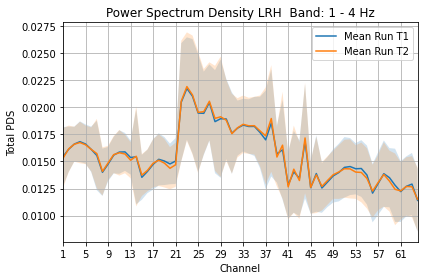

In [ ]:

plt.figure()
plt.plot(channels, total_mean_t1, label = f"Mean Run T1")
plt.plot(channels, total_mean_t2, label = f"Mean Run T2")
plt.fill_between(channels, total_mean_t1 - total_std_t1, total_mean_t1 + total_std_t1, alpha=0.2)
plt.fill_between(channels, total_mean_t2 - total_std_t2, total_mean_t2 + total_std_t2, alpha=0.2)

plt.xlabel('Channel')	
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(1, 64)
plt.xticks(channels[::4])
plt.title(f"Power Spectrum Density LRH  Band: {flow} - {fhigh} Hz")
plt.legend()#bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig(f"./images_per_channel/psd_mean_real_LRH_band_{flow}_{fhigh}.png", dpi=300)
plt.show()

In [ ]:
total_real_t1 = total_mean_t1
total_real_t2 = total_mean_t2
total_real_t1_std = total_std_t1
total_real_t2_std = total_std_t2

# Save data
df = pd.DataFrame(total_mean_t1)
df.to_csv('real_mean_t1.csv', index=False)
df = pd.DataFrame(total_mean_t2)	
df.to_csv('real_mean_t2.csv', index=False)
df = pd.DataFrame(total_std_t1)
df.to_csv('real_std_t1.csv', index=False)
df = pd.DataFrame(total_std_t2)
df.to_csv('real_std_t2.csv', index=False)

df = pd.DataFrame(total_mean_t1_1)
df.to_csv('real_all_t1.csv', index=False)
df = pd.DataFrame(total_mean_t2_1)
df.to_csv('real_all_t2.csv', index=False)

In [ ]:
total_mean_t1_1.shape

(87, 64)

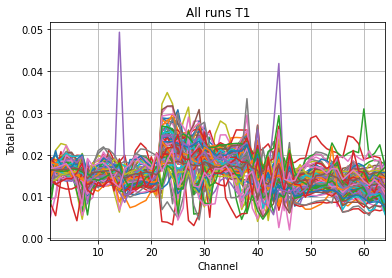

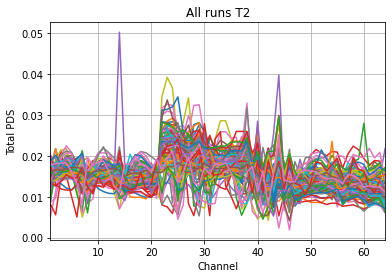

In [ ]:
plt.figure()
for i in range(total_mean_t1_1.shape[0]):
	plt.plot(channels, total_mean_t1_1[i], label = f"Mean Run T1")
plt.title('All runs T1')
plt.xlabel('Channel')
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(1, 64)
plt.grid()
plt.savefig(f"./images_per_channel/psd_mean_all_runs_T1_LRH_band_{flow}_{fhigh}.png", dpi=300)
plt.show()

plt.figure()
for i in range(total_mean_t2_1.shape[0]):
	plt.plot(channels, total_mean_t2_1[i], label = f"Mean Run T2")
plt.title('All runs T2')
plt.xlabel('Channel')
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(1, 64)
plt.grid()
plt.savefig(f"./images_per_channel/psd_mean_all_runs_T2_LRH_band_{flow}_{fhigh}.png", dpi=300)
plt.show()


## imaginada

In [ ]:
tasks = [4, 8, 12]
channels = np.arange(1, 65, 1)
fs = 160

nfft = 4096
nperseg = 16
noverlap = 8
f_cutoff_hp = 1

t_left = 1
t_right = 3

flow=1
fhigh=4

total_mean_t1 = []
total_mean_t2 = []

for session in range(1, 88):
	session = session
	print(session)
	psd_mean_t1, psd_mean_t2 = band_analysis_runs_mean(session, tasks, fs, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
	total_mean_t1.append(psd_mean_t1)
	total_mean_t2.append(psd_mean_t2)


total_mean_t1 = np.array(total_mean_t1)
total_mean_t2 = np.array(total_mean_t2)

total_mean_t1_1 = total_mean_t1
total_mean_t2_1 = total_mean_t2

total_std_t1 = np.std(total_mean_t1, axis=0)
total_std_t2 = np.std(total_mean_t2, axis=0)

total_mean_t1 = np.mean(total_mean_t1, axis=0)
total_mean_t2 = np.mean(total_mean_t2, axis=0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87


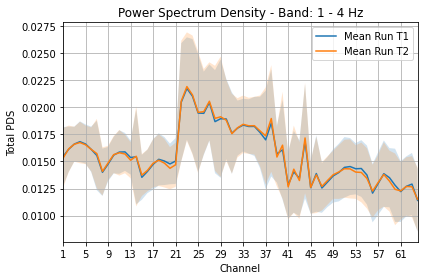

In [ ]:
plt.figure()
plt.plot(channels, total_mean_t1, label = f"Mean Run T1")
plt.plot(channels, total_mean_t2, label = f"Mean Run T2")
plt.fill_between(channels, total_mean_t1 - total_std_t1, total_mean_t1 + total_std_t1, alpha=0.2)
plt.fill_between(channels, total_mean_t2 - total_std_t2, total_mean_t2 + total_std_t2, alpha=0.2)

plt.xlabel('Channel')	
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(1, 64)
plt.xticks(channels[::4])
plt.title(f"Power Spectrum Density - Band: {flow} - {fhigh} Hz")
plt.legend()#bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig(f"./images_per_channel/psd_mean_imag_LRH_band_{flow}_{fhigh}.png", dpi=300)
plt.show()

In [ ]:
total_imag_t1 = total_mean_t1
total_imag_t2 = total_mean_t2
total_imag_t1_std = total_std_t1
total_imag_t2_std = total_std_t2

# Save data
df = pd.DataFrame(total_mean_t1)
df.to_csv('imag_mean_t1.csv', index=False)
df = pd.DataFrame(total_mean_t2)	
df.to_csv('imag_mean_t2.csv', index=False)
df = pd.DataFrame(total_std_t1)
df.to_csv('imag_std_t1.csv', index=False)
df = pd.DataFrame(total_std_t2)
df.to_csv('imag_std_t2.csv', index=False)

df = pd.DataFrame(total_mean_t1_1)
df.to_csv('imag_all_t1.csv', index=False)
df = pd.DataFrame(total_mean_t2_1)
df.to_csv('imag_all_t2.csv', index=False)

## Comparación realizada-imaginada

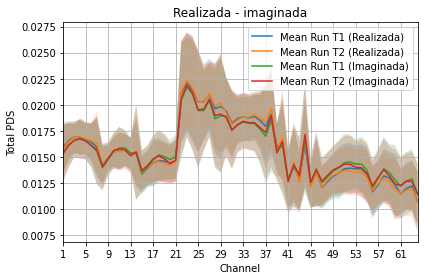

In [ ]:
plt.figure()
plt.plot(channels, total_real_t1, label = f"Mean Run T1 (Realizada)")
plt.plot(channels, total_real_t2, label = f"Mean Run T2 (Realizada)")
plt.fill_between(channels, total_real_t1 - total_real_t1_std, total_real_t1 + total_real_t1_std, alpha=0.2)
plt.fill_between(channels, total_real_t2 - total_real_t2_std, total_real_t2 + total_real_t2_std, alpha=0.2)

plt.plot(channels, total_imag_t1, label = f"Mean Run T1 (Imaginada)")
plt.plot(channels, total_imag_t2, label = f"Mean Run T2 (Imaginada)")
plt.fill_between(channels, total_imag_t1 - total_imag_t1_std, total_imag_t1 + total_imag_t1_std, alpha=0.2)
plt.fill_between(channels, total_imag_t2 - total_imag_t2_std, total_imag_t2 + total_imag_t2_std, alpha=0.2)

plt.xlabel('Channel')	
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(1, 64)
plt.xticks(channels[::4])
plt.title(f"Realizada - imaginada")
plt.legend()#bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig(f"./images_per_channel/psd_comparison_LRH_band_{flow}_{fhigh}.png", dpi=300)
plt.show()

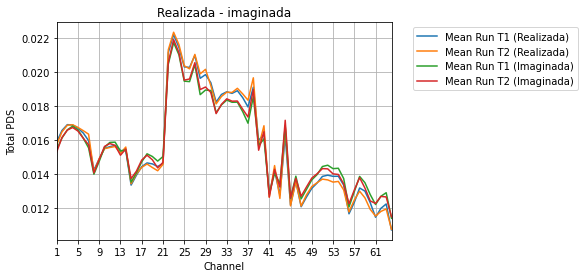

In [ ]:
plt.figure()
plt.plot(channels, total_real_t1, label = f"Mean Run T1 (Realizada)")
plt.plot(channels, total_real_t2, label = f"Mean Run T2 (Realizada)")


plt.plot(channels, total_imag_t1, label = f"Mean Run T1 (Imaginada)")
plt.plot(channels, total_imag_t2, label = f"Mean Run T2 (Imaginada)")


plt.xlabel('Channel')	
plt.ylabel('Total PDS')
#plt.ylim(0, 1)
plt.xlim(1, 64)
plt.xticks(channels[::4])
plt.title(f"Realizada - imaginada")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid()
plt.show()

# Función completa

In [23]:
band_dict = {"delta": (0.1, 4), "theta": (4, 8), "alpha": (8, 12), "beta": (12, 30), "gamma": (30, 80)}

In [24]:
def complete_analysis(band="alpha", real_imag="real"):
	channels = np.arange(1, 65, 1)
	fs = 160

	real_imag_dict = {"real": ["real", 3, 7, 11], "imag": ["imag", 4, 8, 12]}

	nfft = 4096
	nperseg = 16
	noverlap = 8
	f_cutoff_hp = 1

	t_left = 1
	t_right = 3

	tasks = real_imag_dict[real_imag][1:]
	real_im = real_imag_dict[real_imag][0]

	limits = (band_dict[band][0]*(0.9), band_dict[band][1]*(1.2))
	flow=limits[0]
	fhigh=limits[1]

	total_mean_t1 = []
	total_mean_t2 = []

	for session in range(2, 88):
		session = session

		psd_mean_t1, psd_mean_t2 = band_analysis_runs_mean(session, tasks, fs, t_left, t_right, f_cutoff_hp, flow, fhigh, nfft)
		total_mean_t1.append(psd_mean_t1)
		total_mean_t2.append(psd_mean_t2)

	total_mean_t1 = np.array(total_mean_t1)
	total_mean_t2 = np.array(total_mean_t2)

	total_mean_t1_1 = total_mean_t1
	total_mean_t2_1 = total_mean_t2

	total_std_t1 = np.std(total_mean_t1, axis=0)
	total_std_t2 = np.std(total_mean_t2, axis=0)

	total_mean_t1 = np.mean(total_mean_t1, axis=0)
	total_mean_t2 = np.mean(total_mean_t2, axis=0)

	plt.figure()
	plt.plot(channels, total_mean_t1, label = f"Mean Run T1")
	plt.plot(channels, total_mean_t2, label = f"Mean Run T2")
	plt.fill_between(channels, total_mean_t1 - total_std_t1, total_mean_t1 + total_std_t1, alpha=0.2)
	plt.fill_between(channels, total_mean_t2 - total_std_t2, total_mean_t2 + total_std_t2, alpha=0.2)

	plt.xlabel('Channel')	
	plt.ylabel('Total PDS')
	#plt.ylim(0, 1)
	plt.xlim(1, 64)
	plt.xticks(channels[::4])
	plt.title(f"Power Spectrum Density LRH ({real_im})  Band: {band}")
	plt.legend()#bbox_to_anchor=(1.05, 1.0), loc='upper left')
	plt.grid()
	plt.tight_layout()
	plt.savefig(f"./images_per_channel/psd_{real_im}_LRH_band_{band}.png", dpi=300)
	plt.show()

	# Save data
	df = pd.DataFrame(total_mean_t1)
	df.to_csv(f'{real_im}_mean_t1_{band}.csv', index=False)
	df = pd.DataFrame(total_mean_t2)	
	df.to_csv(f'{real_im}_mean_t2_{band}.csv', index=False)
	df = pd.DataFrame(total_std_t1)
	df.to_csv(f'{real_im}_std_t1_{band}.csv', index=False)
	df = pd.DataFrame(total_std_t2)
	df.to_csv(f'{real_im}_std_t2_{band}.csv', index=False)

	df = pd.DataFrame(total_mean_t1_1)
	df.to_csv(f'{real_im}_all_t1_{band}.csv', index=False)
	df = pd.DataFrame(total_mean_t2_1)
	df.to_csv(f'{real_im}_all_t2_{band}.csv', index=False)

In [25]:
def comparison(band="alpha"):
    
	total_real_t1 = pd.read_csv(f'real_mean_t1_{band}.csv').to_numpy().reshape((64))
	total_real_t2 = pd.read_csv(f'real_mean_t2_{band}.csv').to_numpy().reshape((64))
	total_real_t1_std = pd.read_csv(f'real_std_t1_{band}.csv').to_numpy().reshape((64))
	total_real_t2_std = pd.read_csv(f'real_std_t2_{band}.csv').to_numpy().reshape((64))

	total_imag_t1 = pd.read_csv(f'imag_mean_t1_{band}.csv').to_numpy().reshape((64))
	total_imag_t2 = pd.read_csv(f'imag_mean_t2_{band}.csv').to_numpy().reshape((64))
	total_imag_t1_std = pd.read_csv(f'imag_std_t1_{band}.csv').to_numpy().reshape((64))
	total_imag_t2_std = pd.read_csv(f'imag_std_t2_{band}.csv').to_numpy().reshape((64))



	channels = np.arange(1, 65, 1)

	plt.figure()
	plt.plot(channels, total_real_t1, label = f"Mean Run T1 (Realizada)")
	plt.fill_between(channels, total_real_t1 - total_real_t1_std, total_real_t1 + total_real_t1_std, alpha=0.2)
	
	plt.plot(channels, total_real_t2, label = f"Mean Run T2 (Realizada)")
	plt.fill_between(channels, total_real_t2 - total_real_t2_std, total_real_t2 + total_real_t2_std, alpha=0.2)

	plt.plot(channels, total_imag_t1, label = f"Mean Run T1 (Imaginada)")
	plt.plot(channels, total_imag_t2, label = f"Mean Run T2 (Imaginada)")
	plt.fill_between(channels, total_imag_t1 - total_imag_t1_std, total_imag_t1 + total_imag_t1_std, alpha=0.2)
	plt.fill_between(channels, total_imag_t2 - total_imag_t2_std, total_imag_t2 + total_imag_t2_std, alpha=0.2)

	plt.xlabel('Channel')	
	plt.ylabel('Total PDS')
	#plt.ylim(0, 1)
	plt.xlim(1, 64)
	plt.xticks(channels[::4])
	plt.title(f"Comparación Realizada - imaginada ({band})")
	plt.legend()#bbox_to_anchor=(1.05, 1.0), loc='upper left')
	plt.grid()
	plt.tight_layout()
	plt.savefig(f"./images_per_channel/psd_comparison_LRH_band_{band}.png", dpi=300)
	plt.show()

delta


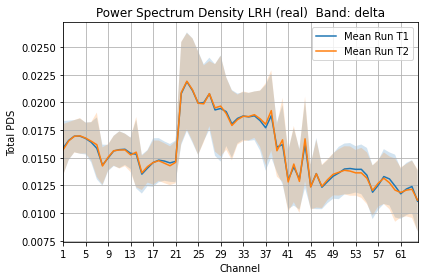

Realizadas terminado


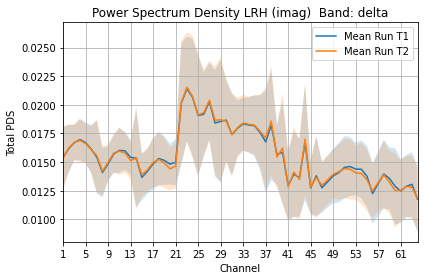

Imaginadas terminado


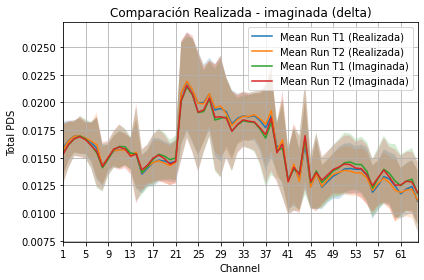

Comparación terminada
theta


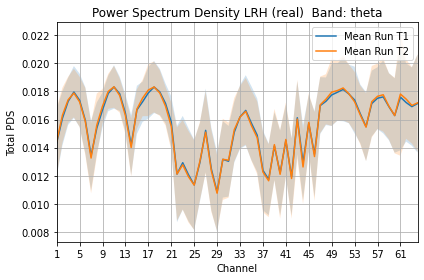

Realizadas terminado


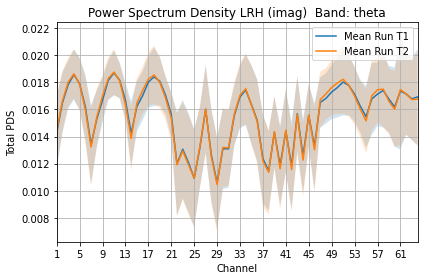

Imaginadas terminado


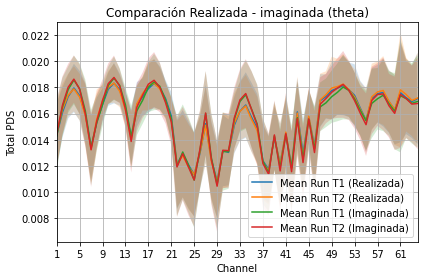

Comparación terminada
alpha


KeyboardInterrupt: 

In [26]:
for band in band_dict.keys():
	print(band)
	complete_analysis(band=band, real_imag="real")
	print("Realizadas terminado")
	complete_analysis(band=band, real_imag="imag")
	print("Imaginadas terminado")
	comparison(band=band)
	print("Comparación terminada")